# Importing the Required Libraries

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import svm,neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D
from keras.callbacks import ReduceLROnPlateau

# Loading the Dataset

In [ ]:
"""The CSV file we are using here contains 10 year details 
of 5 stocks - RELIANCE, HDFC, TCS, ITC and INFOSYS """

df = pd.read_csv("/content/stock_data.csv")
df.head()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,RELIANCE,27-09-2010,504.000000,509.950012,502.549988,505.100006,435.443329,7527416
1,RELIANCE,28-09-2010,504.149994,506.000000,496.500000,499.250000,430.400024,8998180
2,RELIANCE,29-09-2010,500.000000,504.500000,497.500000,499.500000,430.615540,8133008
3,RELIANCE,30-09-2010,501.000000,501.000000,489.049988,493.625000,425.550812,13249458
4,RELIANCE,01-10-2010,496.000000,505.000000,495.000000,503.950012,434.451904,8733722


In [ ]:
df['Date'] = df['Date'].astype('datetime64[ns]')
df.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
12317,INFY,2020-09-21,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637
12318,INFY,2020-09-22,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762
12319,INFY,2020-09-23,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204
12320,INFY,2020-09-24,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432
12321,INFY,2020-09-25,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079


# Feature Extraction

In [ ]:
"""
The individual stocks data consists of Date, Open, 
High, Low, Close and Volume. Using this data we calculated 
our features based on various technical indicators
"""

df['signal'] = 0.0
df['short_mavg'] = df['Close'].rolling(window=30, min_periods=1, center=False).mean()
df['long_mavg'] = df['Close'].rolling(window=120, min_periods=1, center=False).mean()
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)

In [ ]:
def EMA(df, n):
    """ Function to calculate exponential moving average"""
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

df['EMA21'] = EMA(df, 21)
df['EMA63'] = EMA(df, 63)
df['EMA252'] = EMA(df, 252)
df.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,long_mavg,EMA21,EMA63,EMA252
12317,INFY,2020-09-21,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637,1.0,953.335002,795.850002,962.985119,903.096179,789.279139
12318,INFY,2020-09-22,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762,1.0,955.303335,799.023335,967.031927,906.358798,791.004205
12319,INFY,2020-09-23,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204,1.0,957.463334,802.175418,971.824479,909.902273,792.812472
12320,INFY,2020-09-24,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432,1.0,958.270001,805.280418,972.149528,911.949078,794.255852
12321,INFY,2020-09-25,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079,1.0,960.036668,808.787918,975.281387,914.906919,795.934462


In [ ]:
def ROC(df, n):
    """Function to calculate Rate of Change""" 
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
    
df['ROC21'] = ROC(df['Close'], 21)
df['ROC63'] = ROC(df['Close'], 63)

In [ ]:
def MOM(df, n):
    """Function to calculate price momentum"""
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
df['MOM21'] = MOM(df['Close'], 21)
df['MOM63'] = MOM(df['Close'], 63)

In [ ]:
def RSI(series, period):
    """Function to calculate Relative Strength Index"""
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]

    #first value is sum of avg gains
    u[u.index[period-1]] = np.mean( u[:period] ) 
    u = u.drop(u.index[:(period-1)])

    #first value is sum of avg losses
    d[d.index[period-1]] = np.mean( d[:period] ) 
    d = d.drop(d.index[:(period-1)])
    rs = u.rolling(period-1).mean() / d.rolling(period-1).mean()
    return 100 - 100 / (1 + rs)

df['RSI21'] = RSI(df['Close'], 21)
df['RSI63'] = RSI(df['Close'], 63)
df['RSI252'] = RSI(df['Close'], 252)

In [ ]:
#calculation of stochastic osillator.
def STOK(close, low, high, n):
    """Function to calculate Fast Stochastic Oscillator"""
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    return STOK

def STOD(close, low, high, n):
    """Function to calculate Slow Stochastic Oscillator
     (3-period moving average of STOK) """
    STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
    STOD = STOK.rolling(3).mean()
    return STOD

df['%K21'] = STOK(df['Close'], df['Low'], df['High'], 21)
df['%D21'] = STOD(df['Close'], df['Low'], df['High'], 21)
df['%K63'] = STOK(df['Close'], df['Low'], df['High'], 63)
df['%D63'] = STOD(df['Close'], df['Low'], df['High'], 63)
df['%K252'] = STOK(df['Close'], df['Low'], df['High'], 252)
df['%D252'] = STOD(df['Close'], df['Low'], df['High'], 252)
df.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,MOM63,RSI21,RSI63,RSI252,%K21,%D21,%K63,%D63,%K252,%D252
12317,INFY,2020-09-21,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637,1.0,953.335002,...,295.750000,63.706148,69.117661,52.909335,82.254019,85.253951,93.748155,94.984000,95.955922,96.772803
12318,INFY,2020-09-22,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762,1.0,955.303335,...,307.000000,65.694272,66.972127,52.815361,80.235496,81.726694,92.679128,93.557188,95.495927,95.922805
12319,INFY,2020-09-23,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204,1.0,957.463334,...,271.549988,65.624306,68.954864,53.022923,86.188954,82.892823,94.484412,93.637232,96.731407,96.061085
12320,INFY,2020-09-24,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432,1.0,958.270001,...,243.650024,55.425848,64.968443,52.435301,50.680573,72.368341,80.303765,89.155768,88.327811,93.518382
12321,INFY,2020-09-25,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079,1.0,960.036668,...,270.649964,62.711568,66.608232,53.158192,75.660514,70.843347,90.105769,88.297982,94.239692,93.099637


In [ ]:
def MA(df, n):
    """Function to calculate moving average"""
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
    
df['MA21'] = MA(df, 21)
df['MA63'] = MA(df, 63)
df['MA252'] = MA(df, 252)
df.tail()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
12317,INFY,2020-09-21,1001.000000,1031.000000,1000.500000,1009.900024,1009.900024,14140637,1.0,953.335002,...,52.909335,82.254019,85.253951,93.748155,94.984000,95.955922,96.772803,952.550002,905.184923,762.235912
12318,INFY,2020-09-22,1009.000000,1022.500000,991.200012,1007.500000,1007.500000,12625762,1.0,955.303335,...,52.815361,80.235496,81.726694,92.679128,93.557188,95.495927,95.922805,955.411906,910.057939,762.949404
12319,INFY,2020-09-23,1020.150024,1037.000000,1008.099976,1019.750000,1019.750000,13486204,1.0,957.463334,...,53.022923,86.188954,82.892823,94.484412,93.637232,96.731407,96.061085,959.300002,914.368256,763.697420
12320,INFY,2020-09-24,1003.000000,1009.000000,970.000000,975.400024,975.400024,14427432,1.0,958.270001,...,52.435301,50.680573,72.368341,80.303765,89.155768,88.327811,93.518382,960.471433,918.235717,764.275000
12321,INFY,2020-09-25,975.799988,1014.900024,975.000000,1006.599976,1006.599976,13311079,1.0,960.036668,...,53.158192,75.660514,70.843347,90.105769,88.297982,94.239692,93.099637,963.307146,922.531748,765.012698


In [ ]:
# Dealing with rows that contain NAN
df.isnull().sum()
dfub=df.dropna()
dfub.isnull().sum()
dfub.head()

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume,signal,short_mavg,...,RSI252,%K21,%D21,%K63,%D63,%K252,%D252,MA21,MA63,MA252
502,RELIANCE,2012-01-10,420.000000,421.149994,414.625000,416.750000,374.461090,3982938,1.0,403.820832,...,50.437264,60.427823,60.441532,72.506437,72.515961,69.174393,69.181576,407.645236,387.737697,385.166567
503,RELIANCE,2012-03-10,417.225006,426.725006,417.125000,423.049988,380.121765,10013278,1.0,404.351665,...,50.671821,70.267998,64.722556,79.708483,75.612084,74.606587,71.516850,409.622617,388.608729,385.263591
504,RELIANCE,2012-04-10,425.274994,429.450012,424.549988,426.450012,383.176819,5772464,1.0,405.103333,...,50.777746,75.595274,68.763698,83.595336,78.603418,77.538274,73.773085,411.367856,389.550396,385.353273
505,RELIANCE,2012-05-10,429.950012,431.000000,341.174988,428.899994,385.378235,7184276,1.0,406.158332,...,51.221567,88.055213,77.972828,88.055213,83.786344,79.650783,77.265215,413.430950,390.495634,385.451389
506,RELIANCE,2012-08-10,427.274994,427.274994,408.125000,409.700012,368.126465,9551586,1.0,406.780000,...,50.832579,68.782960,77.477816,68.782960,80.144503,63.095507,73.428188,414.649998,391.166666,385.513293


# Splitting the dataset

In [ ]:
X_1=dfub.drop(['signal'],axis=1)
y = dfub['signal']
X_train, X_test, Y_train, Y_test = train_test_split(X_1, y, test_size=0.2, random_state=1)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)

(9456, 29) (9456,)
(2364, 29) (2364,)


# Training and Evaluation of different ML Models

In [ ]:
from sklearn.preprocessing import RobustScaler
X_train_1=X_train.drop(['Close','Date','Symbol','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
X_test_1=X_test.drop(['Close','Symbol','Date','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

rs = RobustScaler()
rs.fit(X_train_1)
X_train_std = rs.transform(X_train_1)
X_test_std = rs.transform(X_test_1)

In [ ]:
# Algorithms
data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('SVM', SVC()))
data_Selected.append(('RF', RandomForestClassifier()))

# evaluate each model in turn
results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=10)
    cv_results =cross_val_score(model, X_train_std, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

KNN: 0.938981 (0.005140)
CART: 0.906724 (0.009490)
SVM: 0.899429 (0.007038)
RF: 0.953680 (0.008433)


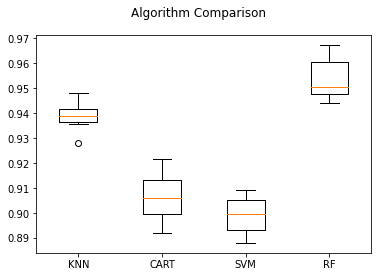

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Feature Selection

In [ ]:
dfubs=dfub.drop(['Date','Symbol','Adj Close','Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
#dfubs.head()
X=dfubs.drop(['signal'], axis=1)
y=dfubs['signal']
forest = RandomForestClassifier(n_estimators=500,random_state=1,n_jobs=-1)
forest.fit(X, y)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=1)

        Importance
MA63      2.402532
EMA252    2.494578
EMA21     2.511547
MA21      2.553359
EMA63     2.613725
%K63      2.858358
MA252     2.939864
MOM21     3.056853
RSI21     3.215747
RSI252    3.578508
ROC21     3.601025
%D21      3.668962
%D63      3.771269
%K21      4.013667
%K252     7.972976
%D252     9.827961
MOM63    12.671832
RSI63    13.082054
ROC63    13.165183


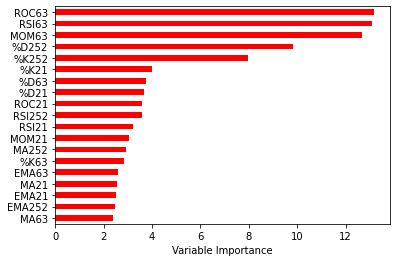

In [ ]:
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# Deep Learning Model

#### LSTM

In [ ]:
def create_window(data, window_size = 1):
    """Function to create window for the LSTM model"""  
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

In [ ]:
def data_to_model(dfm, window):
    """the top 5 features according to the importance values
       calculated using the Random Forest are considered"""
       
    scaler=MinMaxScaler(feature_range=(0,1))
    dg=pd.DataFrame(scaler.fit_transform(dfm[["ROC63","RSI63","MOM63",
                                              "%D252","%K252", "signal"]].values))
    X=dg[[0,1,2,3,4]]
    X=create_window(X,window)
    X=np.reshape(X.values,(X.shape[0],window+1,5))
    
    y=np.array(dg[5][window:])
    
    return X,y

In [ ]:
def model_lstm(window,features):
    
    model=Sequential()
    model.add(Conv1D(input_shape=(window,features),filters=32,kernel_size=2,
                     strides=1,activation='relu',padding='same'))
    model.add(Conv1D(filters=64,kernel_size=2,strides=1,activation='relu',padding='same'))
    model.add(LSTM(300, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(200,  return_sequences=False)) # there is no need to specify input_shape here
    model.add(Dropout(0.5))
    model.add(Dense(100,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=0.001))
    
    
    return model

In [ ]:
window=5
X,y=data_to_model(dfubs,window)

mtest=100
X_train=X[:-mtest-1,:,:]
X_test=X[-mtest-1:,:,:]
y_train=y[:-mtest-1]
y_test=y[-mtest-1:]

In [ ]:
model_lstm=model_lstm(window+1,5)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 32)             352       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 64)             4160      
                                                                 
 lstm (LSTM)                 (None, 6, 300)            438000    
                                                                 
 dropout (Dropout)           (None, 6, 300)            0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               400800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 100)               2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=25, verbose=1,\
                                                 factor=0.25, min_lr=0.00001)

In [ ]:
history_lstm=model_lstm.fit(X_train,y_train,epochs=20, batch_size=24, validation_data=(X_test, y_test), \
                  verbose=1, callbacks=[learning_rate_reduction],shuffle=False)

Epoch 1/20
489/489 [==============================] - 30s 51ms/step - loss: 0.2320 - val_loss: 0.1161 - lr: 0.0010
Epoch 2/20
489/489 [==============================] - 24s 48ms/step - loss: 0.1828 - val_loss: 0.0620 - lr: 0.0010
Epoch 3/20
489/489 [==============================] - 24s 49ms/step - loss: 0.1680 - val_loss: 0.0604 - lr: 0.0010
Epoch 4/20
489/489 [==============================] - 24s 48ms/step - loss: 0.1617 - val_loss: 0.0715 - lr: 0.0010
Epoch 5/20
489/489 [==============================] - 24s 48ms/step - loss: 0.1503 - val_loss: 0.0864 - lr: 0.0010
Epoch 6/20
489/489 [==============================] - 25s 51ms/step - loss: 0.1422 - val_loss: 0.1137 - lr: 0.0010
Epoch 7/20
489/489 [==============================] - 24s 49ms/step - loss: 0.1353 - val_loss: 0.1472 - lr: 0.0010
Epoch 8/20
489/489 [==============================] - 23s 48ms/step - loss: 0.1295 - val_loss: 0.1283 - lr: 0.0010
Epoch 9/20
489/489 [==============================] - 24s 48ms/step - loss: 0.12

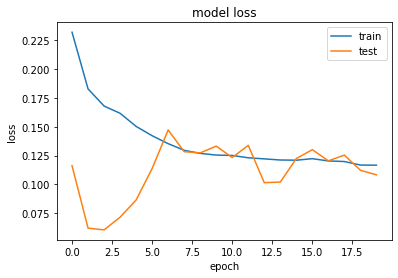

In [ ]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
#saving the model
model_lstm.save_weights("lstm_weights.h5")

#### Model Evaluation

In [ ]:
y_pred_lstm=model_lstm.predict(X_test)
w_lstm=np.diff(y_pred_lstm.reshape(y_pred_lstm.shape[0]),1)
v_lstm=np.maximum(np.sign(w_lstm),0)

In [ ]:
def buy_sell_indicator(price, v_lstm):
    """This function gives us the time-stamp (day) 
       for buying and selling the stock"""
    buy = []
    sell = []
    flag = 0

    for i in range(len(v_lstm)):

        if v_lstm[i] == 1:
            if flag == 0:
                buy.append(price[i])
                sell.append(np.nan)
                flag = 1
            else:
                buy.append(np.nan)
                sell.append(np.nan)

        else:
            if flag == 1: 
                buy.append(np.nan)
                sell.append(price[i])
                flag = 0
            else:
                buy.append(np.nan)
                sell.append(np.nan)

    return buy, sell

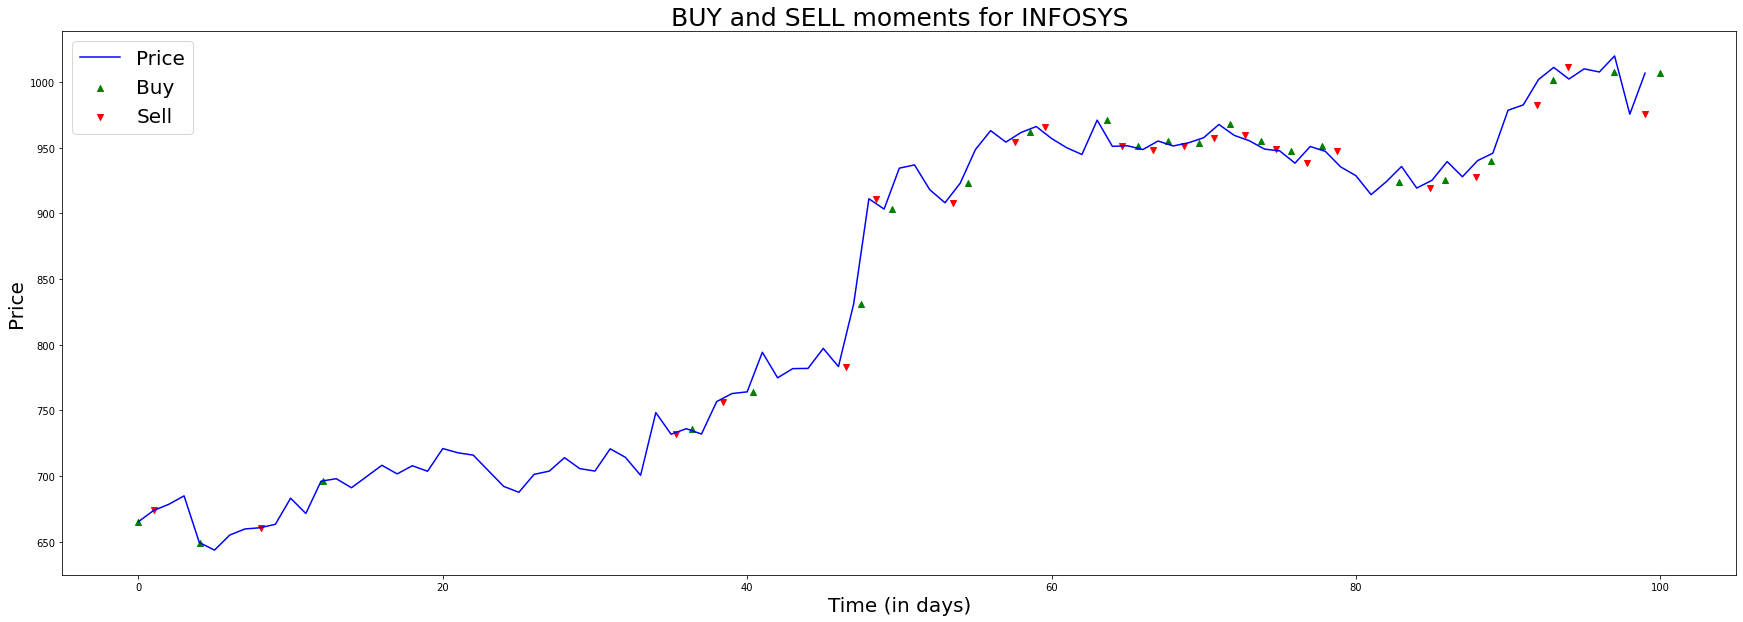

In [ ]:
plt.figure(figsize=(30,10))
price = list(dfub['Adj Close'][-mtest:])
plt.plot(price, label = "Price", color = "blue")

buy, sell = buy_sell_indicator(price, v_lstm)
x = np.linspace(0,100,num = 100)
plt.scatter(x, buy, label = "Buy", marker = "^", color = "g")
plt.scatter(x, sell, label = "Sell", marker = "v", color = "r" )

plt.ylabel("Price", fontsize = 20)
plt.xlabel("Time (in days)", fontsize = 20)
plt.legend(loc = "upper left", fontsize = 20)
plt.title("BUY and SELL moments for INFOSYS",fontsize=25)
plt.show()